# Dépenses de consommation trimestrielles des ménages

## Importation des packages et des données

In [1]:
from pyfile import *

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
#from mlxtend.plotting import plot_pca_correlation_graph
import os
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pyfile import *
cwd = os.getcwd()

yty_var_tot = pd.DataFrame({'Variations de la consommation':var, 'Date':list(conso.index)[4:]})
yty_var_tot = yty_var_tot.set_index('Date').loc['2011T1':]
yty_var_tot = yty_var_tot.diff().iloc[1:,:]

yty_var_tot.index = lesdates[np.arange(2,len(lesdates),3)]

X_selectb = (X[selectionBrut].iloc[:118,:][::-1].diff(periods=12)/X[selectionBrut].iloc[:118,:][::-1].shift(periods=12)).diff(periods=1).iloc[13:,:] # On prend une période de plus
X_selectb.index = lesdates

Y_train = yty_var_tot.iloc[:25]
Y_test = yty_var_tot.iloc[25:]
X_train = X_selectb.iloc[:75,:]
X_test = X_selectb.iloc[75:,:]

yty_var_tot3 = pd.DataFrame()
for i in range(len(X_selectb)):
    yty_var_tot3[i] = pd.Series(np.float64(yty_var_tot.iloc[i//3]))
yty_var_tot3 = yty_var_tot3.T
yty_var_tot3.index = X_selectb.index
yty_var_tot3 = pd.Series(yty_var_tot3[0])

In [74]:

import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
#from mlxtend.plotting import plot_pca_correlation_graph
import os
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pyfile import *
cwd = os.getcwd()

yty_var_tot = pd.DataFrame({'Variations de la consommation':var, 'Date':list(conso.index)[4:]})
#yty_var_tot = yty_var_tot.set_index('Date').loc['2011T1':]
#1991T2
yty_var_tot = yty_var_tot.set_index('Date').loc['1991T1':]
yty_var_tot = yty_var_tot.diff().iloc[1:,:]


import datetime as dt

lesdates =[]
for i in range(len(yty_var_tot)*3):
    annee = 1991+((i+4)//12)
    mois = (i+4)%12
    if mois == 0:
        mois += 12
        annee -= 1
    jour = dernierJour[mois]
    if (annee - 1988)%4 == 0 and mois == 2:
        jour = 29
    lesdates.append(dt.date(annee,mois,jour))
lesdates = pd.Index(lesdates)


yty_var_tot.index = lesdates[np.arange(2,len(lesdates),3)]
X_selectb = (X[selectionBrut].iloc[:358,:][::-1].diff(periods=12)/X[selectionBrut].iloc[:358,:][::-1].shift(periods=12)).diff(periods=1).iloc[13:,:]
X_selectb.index = lesdates

Y_train = yty_var_tot.iloc[:25]
Y_test = yty_var_tot.iloc[25:]
X_train = X_selectb.iloc[:75,:]
X_test = X_selectb.iloc[75:,:]

yty_var_tot3 = pd.DataFrame()
for i in range(len(X_selectb)):
    yty_var_tot3[i] = pd.Series(np.float64(yty_var_tot.iloc[i//3]))
yty_var_tot3 = yty_var_tot3.T
yty_var_tot3.index = X_selectb.index
yty_var_tot3 = pd.Series(yty_var_tot3[0])

In [61]:
X_selectb = X_selectb.dropna()

## Modèle AR(8)

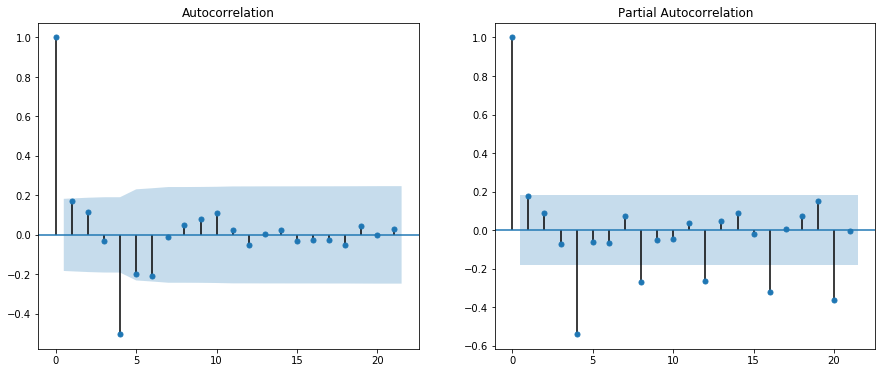

In [57]:
''' Plot des autocorrélations '''

figgg, axxxs = plt.subplots(1,2,figsize=(15,6))
plot_acf(yty_var_tot, ax=axxxs[0])
plot_pacf(yty_var_tot, ax=axxxs[1])
plt.show() # On voit qu'on peut essayer les modèles AR(8), AR(12) et AR(16)
figgg.savefig('Images/acfyty.png')

In [58]:
''' Ajustement des modèles '''

AR8 = sm.tsa.SARIMAX(yty_var_tot, order=(8,0,0)).fit(disp=False)
AR12 = sm.tsa.SARIMAX(yty_var_tot, order=(12,0,0)).fit(disp=False)
AR16 = sm.tsa.SARIMAX(yty_var_tot, order=(16,0,0)).fit(disp=False)

epsilon2 = AR8.resid
ar8_error = (epsilon2**2).sum()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


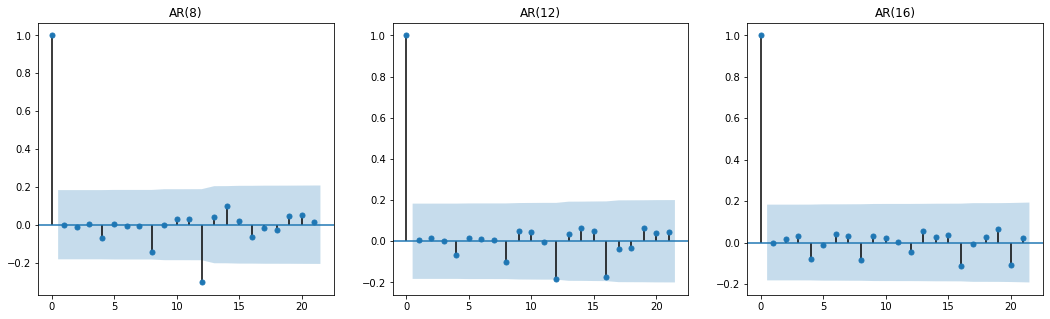

-772.7133742281825 -760.1534275679106 -749.485378645022


In [59]:
''' Plot des autocorrélations des résidus, BIC respectifs '''

figure, axe = plt.subplots(1,3,figsize=(18,5))

plot_acf(AR8.resid,ax=axe[0],title='AR(8)')
plot_acf(AR12.resid,ax=axe[1],title='AR(12)')
plot_acf(AR16.resid,ax=axe[2],title='AR(16)')

plt.show()
figure.savefig('Images/residwhiteness.png')
print(AR8.bic, AR12.bic, AR16.bic)

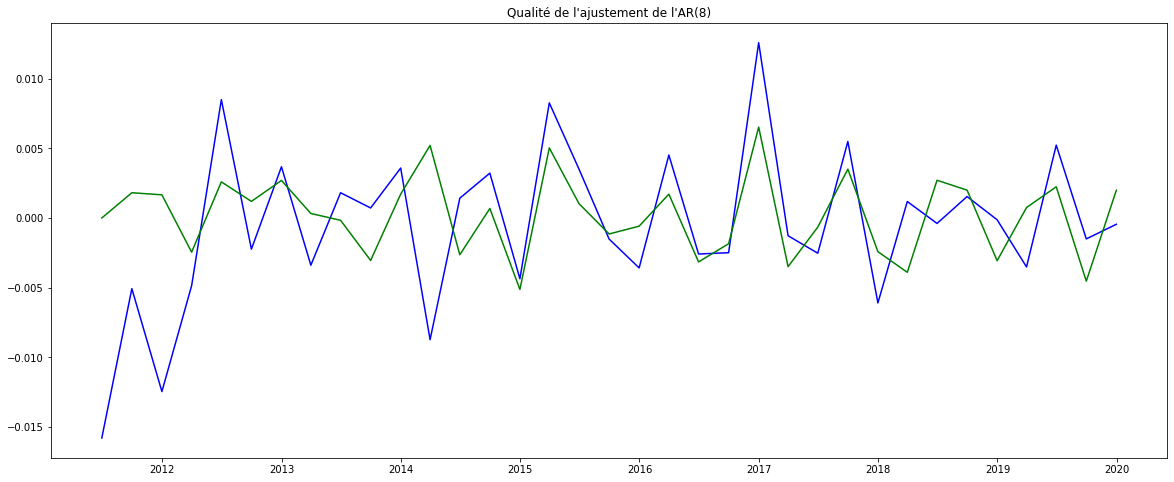

In [7]:
arpredict = AR8.get_prediction()
figure, axe = plt.subplots(figsize=(20,8))
axe.plot(yty_var_tot, color='blue', label='Actual')
axe.plot(arpredict.predicted_mean, color='green',label='AR(8)')
axe.set_title('Qualité de l\'ajustement de l\'AR(8)')
plt.show()
figure.savefig('Images/adjustar.png')

## Échantillonnage de données mélangées, sans contraintes
Unconstrained mixed data sampling - UMIDAS

Soit $t$ dénotant les mois. Les trimestres sont donc dénotés par $3t$. Les séries doivent être stationnaires.

\begin{align*}

Y_{3t} = \alpha + \Phi(B)Y_{3t} + \beta(B)X_{3t}^{'} + \epsilon_t
\\
\text{où :} 
\left\{\begin{array} \, X_t = & (X_{1,t}, \cdots, X_{k,t})
\\
\Phi(B) = & \sum_{i=1}^{p} \Phi_i B^{3i}
\\
\beta(B) = & (\sum_{i=0}^{3p} \beta_{i,1} B^i , \cdots, \sum_{i=0}^{3p} \beta_{i,k} B^i)
\end{array} \right.

\end{align*}

Estimation par MCO : 

\begin{align*}

\hat{\alpha}_{MCO}, \hat{\Phi}_{MCO},\hat{\beta}_{MCO} = \underset{\alpha, \Phi, \beta}{arg min} \sum_{t=p}^T (Y_{3t} - \alpha - \Phi(B)Y_{3t} - \beta(B)X_{3t}^{'})^2

\end{align*}

En posant : 

\begin{align*}

Z_{3t} = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t},X_{1,3t-1},\cdots, X_{1,3t-3p},X_{2,3t},\cdots, X_{k,3t-3p})

\end{align*}

Le problème se réécrit :

\begin{align*}

\underset{\omega \in \mathbb{R}^{1 + p + k(3p+1)}}{arg min} \sum_{t=p}^{T} (Y_{3t} - \omega Z_{3t}^{'} )^2

\end{align*}

Il y a une solution explicite :

\begin{align*}

\hat{\omega}_{MCO} = \mathbb{E}[Z_{3t}^{'} Z_{3t}]^{-1} \mathbb{E}[Z_{3t}^{'}Y_{3t}] \approx (\sum_{t=p}^T Z_{3t}^{'} Z_{3t})^{-1} \sum_{t=p}^TZ_{3t}^{'}Y_{3t}

\end{align*}

Ainsi la prévision nowcast devient :

\begin{align*}

\hat{Y}_{3t + 3} = \hat{\omega}_{MCO} Z_{3t + 3}^{'}

\end{align*}

### Que fait-on lorsque nous n'avons pas tous les mois du trimestre ?

Les données passent de $Z_{3t} = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t},X_{1,3t-1},\cdots, X_{1,3t-3p},X_{2,3t},\cdots, X_{k,3t-3p})$ à $Z_{3t,mois} = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t} \mathbb{1}_{\% 3 \leq mois}(3t),X_{1,3t-1}\mathbb{1}_{\% 3 \leq mois}(3t - 1),\cdots, X_{1,3t-3p} \mathbb{1}_{\% 3 \leq mois}(3t-3p),X_{2,3t} \mathbb{1}_{\% 3 \leq mois}(3t),\cdots, X_{k,3t-3p}\mathbb{1}_{\% 3 \leq mois}(3t-3p))$ où \% désigne le reste de la division euclidienne, et où une valeur constante nulle signifie une absence de donnée.

Une idée peut être de d'abord faire une régression (AR(3p)) des mois suivants en fonction des mois précédents de chaque variable explicative.

On prévoit alors ainsi :

\begin{align*}

\hat{Y}_{3t + 3} = \hat{\omega}_{MCO} \tilde{Z}_{3t + 3}^{'}

\end{align*}

avec $\tilde{Z}_{3t + 3}^{'}$ le vecteur $Z_{3t,mois}$ où l'on a remplacé les zéros par la prédiction par AR(3p) des valeurs manquantes.

In [75]:
X_selectb[X_selectb.isna()] = 0

In [76]:
X_selectb.shape

(345, 10)

In [78]:
''' Calcul de omega '''

p = 4 # On fixe l'ordre de régression p, il faudrait enquêter sur les autocorrélations
k = len(X_selectb.columns)

Z = pd.DataFrame() # Pour tout t, on construit Z_3t dans une liste
for t in np.arange(p,len(yty_var_tot)):
    z = [1]
    for i in np.arange(1,p): # On rajoute les Y_3(t-i)
        z.append(np.float64(yty_var_tot.iloc[t-i]))
    for j in range(k): # On rajoute les X_3t-i
        for l in np.arange(0,3*p):
            z.append(np.float64(X_selectb.iloc[(3*t)-l,j])) # Vérifier qu'on a les bons index#Pour chaque colonne k on récupère les données aux dates 3*t-l (date actuelle moins toute la profondeur de la régression)
    Z[t] = pd.Series(z)

sumdesign = Z @ Z.T
inv_sumdesign = pd.DataFrame(np.linalg.pinv(sumdesign.values)) # Ensuite, on calcule la somme des matrices de design et son inverse
secondfactor = pd.DataFrame(Z.values @ yty_var_tot.iloc[p:].values) # On calcule également la somme des produits Z_3t' par Y_3t

omega = inv_sumdesign @ secondfactor # On multiplie l'inverse de la somme des matrices de design par la somme des produits.

Pour vérifier l'efficacité, on calcule les résidus $Y_{mois} - \hat{\omega} Z_{mois}$

In [79]:
''' Calcul des résidus sur l'échantillon d'entraînement '''

fcst = pd.DataFrame()
for t in np.arange(p,len(yty_var_tot)):
    fcst[t] = omega.T @ Z[t]

fcst = fcst.T
fcst.index = yty_var_tot.index[p:]

epsilon = yty_var_tot['Variations de la consommation'] - fcst[0]

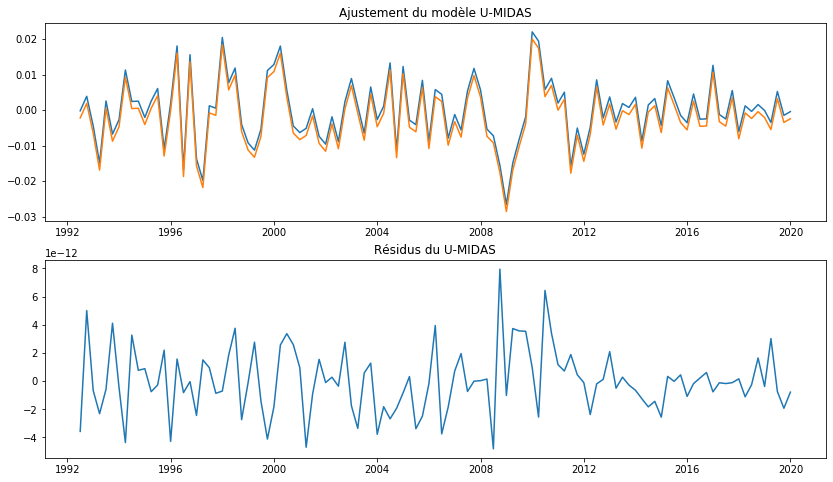

In [80]:
figure, axe = plt.subplots(2,1,figsize=(14,8))
axe[0].plot(fcst.index, fcst)
axe[0].plot(fcst.index, yty_var_tot[p:]-0.002) # On décale un tout petit peu pour voir qqch
axe[0].set_title("Ajustement du modèle U-MIDAS")
axe[1].plot(epsilon)
axe[1].set_title("Résidus du U-MIDAS")
plt.show()

On remarque que le modèle "fit" très bien aux données. Aussi, nous nous sommes placés dans un cadre optimal ou la seule information non disponible est $Y_t$. Nous allons déjà comparer ce modèle à un modèle "naïf" de type ARMA. Ensuite, nous allons étudier le modèle UMIDAS lorsque nous n'avons pas toutes les informations sur les $X_t$.

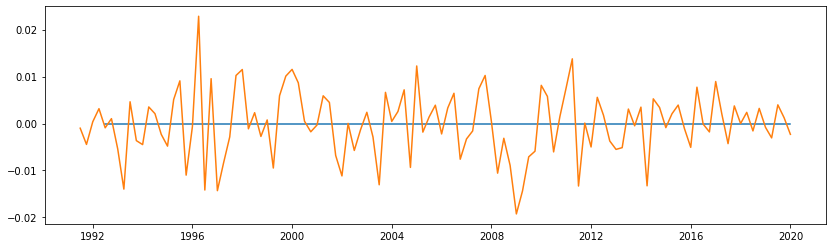

In [81]:
figure, axe = plt.subplots(figsize=(14,4))
axe.plot(epsilon)
axe.plot(epsilon2)
#axe.set_yscale('log')
plt.show()

Le UMIDAS est clairement plus performant que le modèle AR sur la période étudiée. Toutefois, il s'agit d'un échantillon d' "entraînement". Nous allons étudier les modèles sur des échantillons train et test séparés.

Une approche, dite "directe" (cf. Marcellino et al, 2006), est de recalculer les coefficients de la régression pour chaque différents cas (lorsqu'il nous manque 3 mois, 2 mois, 1 mois ou aucun mois). Aussi, là-dessus nous allons ajuster un modèle de régression pour chacun de ces cas. Toutefois, nous allons aussi observer le comportement du modèle dans un cadre dynamique, lorsqu'on ajuste les coefficients au cours du temps avec les nouvelles données.

#### Ajustement des différents $\omega$ pour différentes situations de données manquantes.

Il s'agit de recalculer les coefficients avec 

\begin{align*}

Z_{3t,0} & = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t-3},X_{1,3t-4},\cdots, X_{1,3t-3p},X_{2,3t-3},\cdots, X_{k,3t-3p})
\\ Z_{3t,1} & = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t-2},X_{1,3t-3},\cdots, X_{1,3t-3p},X_{2,3t-2},\cdots, X_{k,3t-3p})
\\ Z_{3t,2} & = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t-1},X_{1,3t-2},\cdots, X_{1,3t-3p},X_{2,3t-1},\cdots, X_{k,3t-3p})
\\ Z_{3t,3} & = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t},X_{1,3t-1},\cdots, X_{1,3t-3p},X_{2,3t},\cdots, X_{k,3t-3p})
\end{align*}

pour chaque $Z_{3t,\text{mois disponibles}}$.

In [82]:
windowLength = 25

## Implémentation du midas en rolling

In [83]:

#We set the length of the rolling training sample   
#windowLength = 25

p = 3 #The length of the MIDAS regression
k = len(X_selectb.columns) #the number of regressors

Zs = []
omegas = []

Y_window = yty_var_tot[0:windowLength] #We create the first training sample 

#We create the collections needed to run the models and estimate their coefficients on the training sample

for situation in range(4):

    Z = pd.DataFrame() # For each time t we build a Z_3t in a list
    for t in np.arange(p,windowLength):
        z = [1]
        for i in np.arange(1,p): # We add the past values of Y (Y(t-i))
            z.append(np.float64(Y_window.iloc[t-i]))
        for j in range(k): # Now we add all the past values of the regressors : X3(t-i)
            for l in np.arange(0,3*p):
                z.append(np.float64(X_selectb.iloc[(3*t)-situation-l,j])) 
        Z[t] = pd.Series(z)
    Zs.append(Z)

    sumdesign = Z @ Z.T
    inv_sumdesign = pd.DataFrame(np.linalg.pinv(sumdesign.values)) 
    secondfactor = pd.DataFrame(Z.values @ Y_window.iloc[p:].values)

    omega = inv_sumdesign @ secondfactor #we compute the estimates of the coefficients of each MIDAS regression on the training sample. 
    omegas.append(omega) 


#Now we will create the regressor collections needed to use ours model to nowcast (1 for each model)

#zsPrévisions = []
#for situation in range(4):
#
#   Z = pd.DataFrame() 
#   t = windowLength
#   z = [1]
#   for i in np.arange(1,p):
#       z.append(np.float64(yty_var_tot.iloc[t-i]))
#   for j in range(k): 
#       for l in np.arange(0,3*p):
#           z.append(np.float64(X_selectb.iloc[(3*t)-situation-l,j])) 
#   zsPrévisions.append(pd.Series(z))

In [84]:
#We us our models to predict on the training sample the same way as the static models. 

toplot = []

for t in np.arange(p,len(Y_window)):
    for situation in range(3):#pourquoi 3 ?
        toplot.append(Zs[2-situation][t] @ omegas[2-situation])

#for situation in range(3):
#        toplot.append(zsPrévisions[2-situation] @ omegas[2-situation])

staticForecast = pd.Series([toplot[i][0] for i in range(len(toplot))])
staticForecast.index = X_selectb.index[3*p:3*p+len(staticForecast)]

#We store oour predictions in a data frame 
rollingMIDASForecast = pd.DataFrame(staticForecast, columns={"Prédictions avec le modèle rolling"})

In [15]:
#prediction = pd.DataFrame(staticPredictions[len(toreallyplot)-p:],columns={"Variations de la consommation"})
#Y_window = pd.concat([Y_train[p:windowLength],prediction],axis=0)

In [85]:
#Now we will predict the next values as if we were nowcasting with a rolling training sample, meaning that we will train our models on a changing training sample and only predict values one step ahead. 

Zs = []
omegas = []

for d in range(p,len(yty_var_tot)-windowLength,4) : 

    Y_window = yty_var_tot[d:d+windowLength] #for each loop we move the training sample

#We do the same thing that we did to train our model on the trainin sample
    for situation in range(4):

        Z = pd.DataFrame() # Pour tout t, on construit Z_3t dans une liste
        
        for t in np.arange(p,windowLength):
            z = [1]
            for i in np.arange(1,p): # On rajoute les Y_3(t-i)
                z.append(np.float64(Y_window.iloc[t-i]))
            for j in range(k): # On rajoute les X_3t-i
                for l in np.arange(0,3*p):
                    z.append(np.float64(X_selectb.iloc[(3*(t+d))-situation-l,j])) # Vérifier qu'on a les bons index #il faut le bon t en décalant pour savoir où on en est
            Z[t] = pd.Series(z)
        Zs.append(Z)
        sumdesign = Z @ Z.T
        inv_sumdesign = pd.DataFrame(np.linalg.pinv(sumdesign.values)) # Ensuite, on calcule la somme des matrices de design et son inverse
        secondfactor = pd.DataFrame(Z.values @ Y_window.iloc[p:].values) # On calcule également la somme des produits Z_3t' par Y_3t

        omega = inv_sumdesign @ secondfactor
        omegas.append(omega)

#Now we will create the regressor collections needed to use ours model to nowcast (1 for each model)
    zsForecast = []
    for situation in range(4):

        Z = pd.DataFrame() 
        t = d+windowLength
        z = [1]
        for i in np.arange(1,p): 
            z.append(np.float64(yty_var_tot.iloc[t-i]))
        for j in range(k): 
            for l in np.arange(0,3*p):
                z.append(np.float64(X_selectb.iloc[(3*t)-situation-l,j]))
        zsForecast.append(pd.Series(z))

    toplot = []

#We predict the values that are one step ahead of the training sample for each model
    for situation in range(3):
            toplot.append(zsForecast[2-situation] @ omegas[2-situation])

    oneStepForecasts = pd.Series([toplot[i][0] for i in range(len(toplot))])
    oneStepForecasts.index = X_selectb.index[3*t:3*t+p]

#We store the prediction
    rollingMIDASForecast = pd.concat([rollingMIDASForecast,pd.DataFrame(oneStepForecasts, columns=rollingMIDASForecast.columns)])


## Implémentation du midas en recursive

In [86]:
#We set the length of the first training sample   
#windowLength = 10

#We proceed roughly the same way as for the rolling MIDAS, that is we predict with a loop and a changing training sample but this time instead of moving it we increase its length. 

p = 3
k = len(X_selectb.columns)

Zs = []
omegas = []

Y_window = yty_var_tot[0:windowLength]

for situation in range(4):

    Z = pd.DataFrame() 
    for t in np.arange(p,windowLength):
        z = [1]
        for i in np.arange(1,p): 
            z.append(np.float64(Y_window.iloc[t-i]))
        for j in range(k): 
            for l in np.arange(0,3*p):
                z.append(np.float64(X_selectb.iloc[(3*t)-situation-l,j])) 
        Z[t] = pd.Series(z)
    Zs.append(Z)
    sumdesign = Z @ Z.T
    inv_sumdesign = pd.DataFrame(np.linalg.pinv(sumdesign.values)) 
    secondfactor = pd.DataFrame(Z.values @ Y_window.iloc[p:].values) 

    omega = inv_sumdesign @ secondfactor
    omegas.append(omega)



In [87]:
toplot = []

for t in np.arange(p,windowLength):
    for situation in range(3):#pourquoi 3 ?
        toplot.append(Zs[2-situation][t] @ omegas[2-situation])

staticMIDASForecasts = pd.Series([toplot[i][0] for i in range(len(toplot))])
staticMIDASForecasts.index = X_selectb.index[3*p:3*p+len(staticMIDASForecasts)]

recursiveMIDASForecast = pd.DataFrame(staticMIDASForecasts, columns={"Prédictions avec le modèle récursif"})

In [88]:
Zs = []
omegas = []

for d in range(windowLength+1,len(yty_var_tot),p) :

    windowLength = d
    Y_window = yty_var_tot[0:d]

    for situation in range(4):

        Z = pd.DataFrame() 
        
        for t in np.arange(p,windowLength):
            z = [1]
            for i in np.arange(1,p): 
                z.append(np.float64(Y_window.iloc[t-i]))
            for j in range(k): 
                for l in np.arange(0,3*p):
                    z.append(np.float64(X_selectb.iloc[(3*(t))-situation-l,j])) 
            Z[t] = pd.Series(z)
        Zs.append(Z)
        sumdesign = Z @ Z.T
        inv_sumdesign = pd.DataFrame(np.linalg.pinv(sumdesign.values)) 
        secondfactor = pd.DataFrame(Z.values @ Y_window.iloc[p:].values) 

        omega = inv_sumdesign @ secondfactor
        omegas.append(omega)

    zsForecast = []
    for situation in range(4):

        Z = pd.DataFrame() 
        t = d
        z = [1]
        for i in np.arange(1,p): 
            z.append(np.float64(yty_var_tot.iloc[t-i]))
        for j in range(k): 
            for l in np.arange(0,3*p):
                z.append(np.float64(X_selectb.iloc[(3*t)-situation-l,j])) 
        zsForecast.append(pd.Series(z))

    toplot = []

    for situation in range(3):
            toplot.append(zsForecast[2-situation] @ omegas[2-situation])

    oneStepForecasts = pd.Series([toplot[i][0] for i in range(len(toplot))])
    oneStepForecasts.index = X_selectb.index[3*t:3*t+p]

    recursiveMIDASForecast = pd.concat([recursiveMIDASForecast,pd.DataFrame(oneStepForecasts, columns=recursiveMIDASForecast.columns)])

## MIDAS "normal"

In [89]:
p = 3 # On fixe l'ordre de régression p, il faudrait enquêter sur les autocorrélations
k = len(X_selectb.columns)

Zs = []
omegas = []


for situation in range(4):

    Z = pd.DataFrame() # Pour tout t, on construit Z_3t dans une liste
    for t in np.arange(p,len(Y_train)):
        z = [1]
        for i in np.arange(1,p): # On rajoute les Y_3(t-i)
            z.append(np.float64(Y_train.iloc[t-i]))
        for j in range(k): # On rajoute les X_3t-i
            for l in np.arange(0,3*p):
                z.append(np.float64(X_train.iloc[(3*t)-situation-l,j])) # Vérifier qu'on a les bons index
        Z[t] = pd.Series(z)
    Zs.append(Z)
    sumdesign = Z @ Z.T
    inv_sumdesign = pd.DataFrame(np.linalg.pinv(sumdesign.values)) # Ensuite, on calcule la somme des matrices de design et son inverse
    secondfactor = pd.DataFrame(Z.values @ Y_train.iloc[p:].values) # On calcule également la somme des produits Z_3t' par Y_3t

    omega = inv_sumdesign @ secondfactor
    omegas.append(omega)

Zstest = []
for situation in range(4):

    Z = pd.DataFrame() # Pour tout t, on construit Z_3t dans une liste
    for t in np.arange(len(Y_train),len(yty_var_tot)):
        z = [1]
        for i in np.arange(1,p): # On rajoute les Y_3(t-i)
            z.append(np.float64(yty_var_tot.iloc[t-i]))
        for j in range(k): # On rajoute les X_3t-i
            for l in np.arange(0,3*p):
                z.append(np.float64(X_selectb.iloc[(3*t)-situation-l,j])) # Vérifier qu'on a les bons index
        Z[t] = pd.Series(z)
    Zstest.append(Z)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


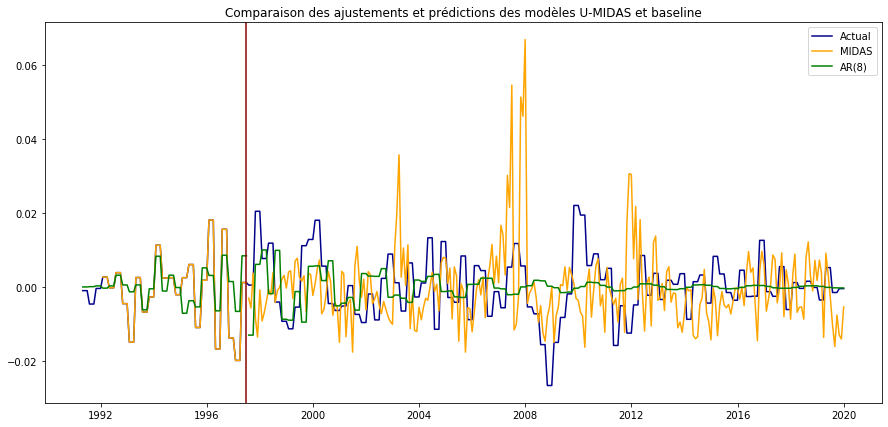

In [90]:
toplot = []

for t in np.arange(p,len(Y_train)):
    for situation in range(3):
        toplot.append(Zs[2-situation][t] @ omegas[2-situation])

#Entraînement MIDAS
toreallyplot = pd.Series([toplot[i][0] for i in range(len(toplot))])
toreallyplot.index = X_train.index[3*p:]

toplot2 = []

for t in range(len(yty_var_tot)-len(Y_train)):
    for situation in range(3):
        toplot2.append(Zstest[2-situation].iloc[:,t] @ omegas[2-situation])

#Test du MIDAS
toreallyplot2 = pd.Series([toplot2[i][0] for i in range(len(toplot2))])
toreallyplot2.index = X_test.index


AR8 = sm.tsa.SARIMAX(Y_train, order=(8,0,0)).fit()
artrainprediction = AR8.get_prediction().predicted_mean
artestprediction = AR8.get_forecast(steps=len(Y_test)).predicted_mean

liste1 = []
liste2 = []
for elt in artrainprediction:
    for i in range(3):
        liste1.append(elt)

for elt in artestprediction:
    for i in range(3):
        liste2.append(elt)

artrainprediction = pd.Series(liste1)
artestprediction = pd.Series(liste2)
artrainprediction.index = X_train.index
artestprediction.index = X_test.index


figure, axe = plt.subplots(figsize=(15,7))
axe.plot(yty_var_tot3, color='darkblue', label='Actual')
axe.plot(toreallyplot, color='orange', label='MIDAS')
axe.plot(toreallyplot2, color='orange')
axe.plot(artrainprediction, color='green' , label='AR(8)')
axe.plot(artestprediction, color='green')
axe.axvline(Y_train.index[-1], color = 'darkred')
axe.set_title("Comparaison des ajustements et prédictions des modèles U-MIDAS et baseline")
plt.legend()
plt.show()


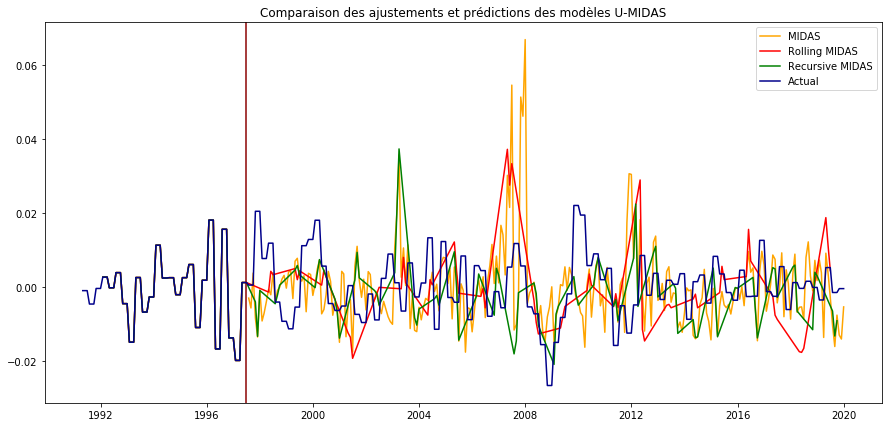

In [91]:
figure, axe = plt.subplots(figsize=(15,7))
axe.plot(toreallyplot, color='orange', label='MIDAS')
axe.plot(toreallyplot2, color='orange')
axe.plot(rollingMIDASForecast, color='red', label="Rolling MIDAS")
axe.plot(recursiveMIDASForecast, color='green', label="Recursive MIDAS")
axe.axvline(Y_train.index[-1], color = 'darkred')
axe.plot(yty_var_tot3, color='darkblue', label='Actual')
axe.set_title("Comparaison des ajustements et prédictions des modèles U-MIDAS")
plt.legend()
plt.show()

## SARIMA avec variables exogènes


In [92]:
''' Aggrégation des variables explicatives en moyennant sur les trimestres '''
# SARIMAX permet de faire un tel modèle
X_selectb_agg = pd.DataFrame([X_selectb.iloc[3*i:3*(i+1),:].mean() for i in range(len(yty_var_tot))], index=yty_var_tot.index)

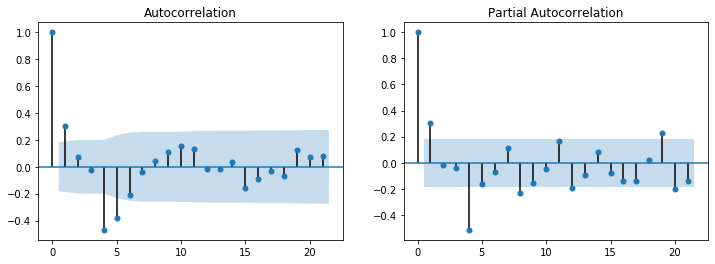

In [93]:
''' On regarde les ordres p et q à appliquer au modèle SARIMAX en enquêtant sur les autocorrélations des résidus de la régression de Y sur X '''

residus = sm.OLS(yty_var_tot,X_selectb_agg).fit().resid

figure, axe = plt.subplots(1,2,figsize=(12,4))
plot_acf(residus,ax=axe[0])
plot_pacf(residus,ax=axe[1]) # On choisit un ARMAX(1,1)
plt.show()
figure.savefig('Images/acfarmax.png')

In [94]:
''' On ajuste le modèle '''
sarima = sm.tsa.SARIMAX(Y_train,X_selectb_agg.iloc[:len(Y_train),:],order=(12,0,0)).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [125]:
len(yty_var_tot)

115

In [127]:
staticSARIMAXForecast = sarima.get_prediction(start=0,end=len(yty_var_tot),endog=yty_var_tot, exog=X_selectb_agg.iloc[len(yty_var_tot)-3:,:]).predicted_mean

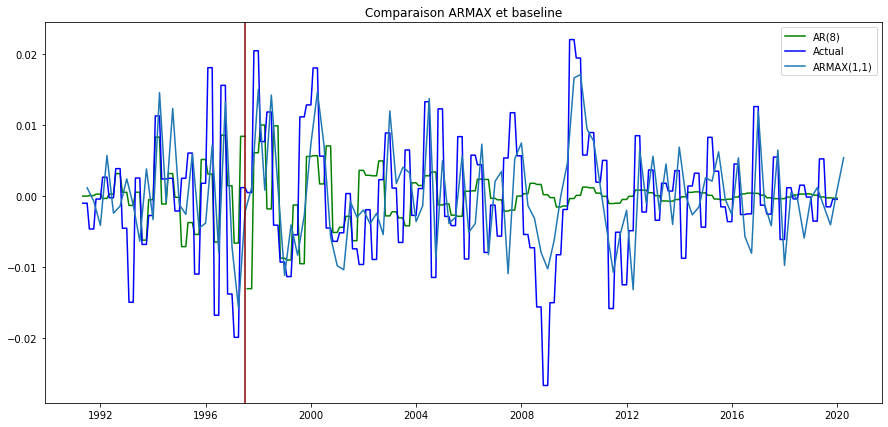

In [128]:
figure, axe = plt.subplots(figsize=(15,7))
axe.plot(artrainprediction, color='green' , label='AR(8)')
axe.plot(artestprediction, color='green')
axe.plot(yty_var_tot3, color='blue', label='Actual')
axe.plot(staticSARIMAXForecast, label='ARMAX(1,1)')
axe.axvline(Y_train.index[-1], color = 'darkred')
axe.set_title('Comparaison ARMAX et baseline')
plt.legend()
plt.show()

## Rolling

In [131]:
windowLength = 25

In [135]:
#windowLength = 13

X = X_selectb_agg

rollingSARIMAXForecast = []

for d in range(1,len(yty_var_tot)-windowLength):
    y_window = yty_var_tot[d:d+windowLength]
    X = X.iloc[1:,:]
    sarima = sm.tsa.SARIMAX(y_window,X.iloc[:windowLength,:],order=(12,0,0)).fit()
    forecasts= sarima.get_prediction(start=0,end=len(yty_var_tot)-1-d,endog=yty_var_tot[d:],exog=X.iloc[windowLength:,:]).predicted_mean
    rollingSARIMAXForecast.append(forecasts[windowLength])


e used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

In [136]:
forecasts = pd.DataFrame(staticSARIMAXForecast[0:windowLength+1],columns={"Prévision"})
rollingSARIMAXForecast = pd.DataFrame(rollingSARIMAXForecast,columns=forecasts.columns)
rollingSARIMAXForecast.index = yty_var_tot.index[windowLength+1:]
rollingSARIMAXForecast = pd.concat([forecasts,rollingSARIMAXForecast])

## Recursive

In [139]:
#windowLength = 13

X = X_selectb_agg

recursiveSARIMAXForecast = []

for trainLength in range(windowLength,len(yty_var_tot)):
    y_window = yty_var_tot[0:trainLength]
    sarima = sm.tsa.SARIMAX(y_window,X.iloc[:trainLength,:],order=(12,0,0)).fit()
    forecasts = sarima.get_prediction(start=0,end=len(yty_var_tot)-1,endog=yty_var_tot[d:],exog=X.iloc[trainLength:,:]).predicted_mean
    recursiveSARIMAXForecast.append(forecasts[trainLength])


eck mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred

In [140]:
forecasts = pd.DataFrame(staticSARIMAXForecast[0:windowLength],columns={"Prévision"})
recursiveSARIMAXForecast = pd.DataFrame(recursiveSARIMAXForecast,columns=forecasts.columns)
recursiveSARIMAXForecast.index = yty_var_tot.index[windowLength:]
recursiveSARIMAXForecast = pd.concat([forecasts,recursiveSARIMAXForecast])

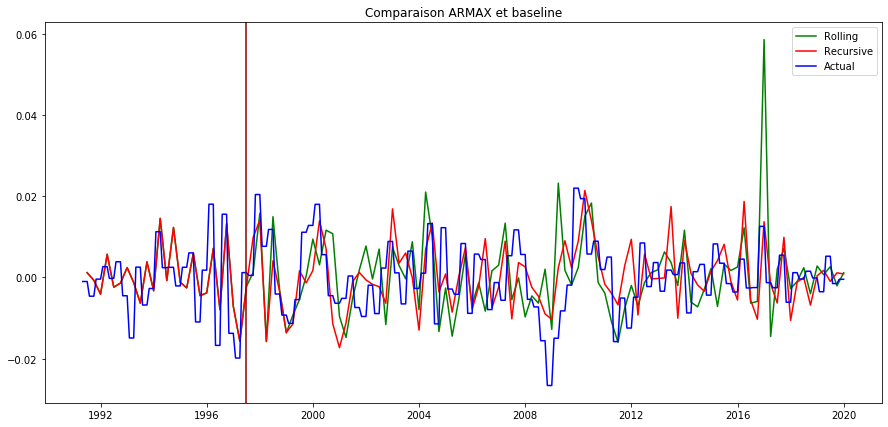

In [141]:
figure, axe = plt.subplots(figsize=(15,7))
axe.plot(rollingSARIMAXForecast, color='green' , label='Rolling')
axe.plot(recursiveSARIMAXForecast, color='red' , label='Recursive')
axe.plot(yty_var_tot3, color='blue', label='Actual')
axe.axvline(Y_train.index[-1], color = 'darkred')
axe.set_title('Comparaison ARMAX et baseline')
plt.legend()
plt.show()

## VAR

In [142]:
time_averaging = pd.DataFrame()
nombre_lags = 8
compteur=0

for i,col in enumerate(X_selectb_agg.columns):
    time_averaging[compteur] = X_selectb_agg.iloc[:,i]
    compteur += 1
    if nombre_lags != 0:
        for l in range(nombre_lags):
            time_averaging[compteur] = X_selectb_agg.iloc[:,i].shift(l+1)
            compteur += 1

time_averaging = time_averaging.iloc[nombre_lags:,:]

y_lags = pd.DataFrame()
if nombre_lags != 0:
    for l in range(nombre_lags):
        y_lags[l+1] = yty_var_tot.shift(l+1).iloc[:,0]

y_lags = y_lags.iloc[nombre_lags:,:]

if nombre_lags == 0:
    regressors = time_averaging
else:
    regressors = pd.concat([y_lags,time_averaging],axis=1)
    
regressors = sm.add_constant(regressors)

In [143]:
var = sm.OLS(Y_train.iloc[nombre_lags:], regressors.iloc[:len(Y_train)-nombre_lags,:]).fit()

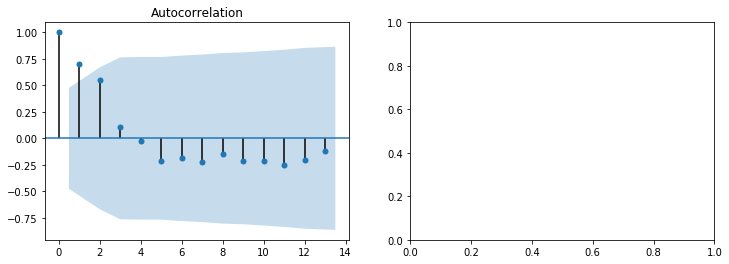

In [144]:
''' On vérifie la blancheur des résidus en regardant les autocorrélations '''

residus = var.resid

figure, axe = plt.subplots(1,2,figsize=(12,4))
plot_acf(residus,ax=axe[0])
plt.show()

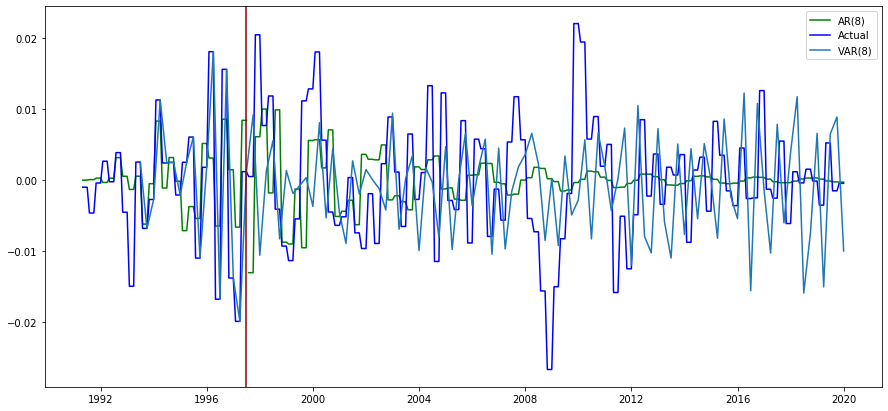

In [145]:
figure, axe = plt.subplots(figsize=(15,7))
axe.plot(artrainprediction, color='green' , label='AR(8)')
axe.plot(artestprediction, color='green')
axe.plot(yty_var_tot3, color='blue', label='Actual')
axe.plot(var.predict(regressors), label='VAR(8)')
axe.axvline(Y_train.index[-1], color = 'darkred')
plt.legend()
plt.show()

## Rolling

In [146]:
windowLength = 12
rollingVARForecast = []

if nombre_lags <= windowLength:

    for d in range(0,len(yty_var_tot)-windowLength):
        
        Y_window = yty_var_tot[d:d+windowLength]
        modelVAR = sm.OLS(Y_window.iloc[nombre_lags:], regressors.iloc[d:d+windowLength-nombre_lags,:]).fit()
        rollingVARForecast.append(modelVAR.predict(regressors.iloc[(d+windowLength-nombre_lags):,:])[0])

    rollingVARForecast = pd.DataFrame(rollingVARForecast, columns={"Prévision en rolling"})
    rollingVARForecast.index = yty_var_tot.index[windowLength:len(yty_var_tot)]

## Récursive

In [147]:
windowLength = 12
recursiveVARForecast = []

if nombre_lags <= windowLength:

    for d in range(0,len(yty_var_tot)-windowLength):
        
        Y_window = yty_var_tot[0:d+windowLength]
        modelVAR = sm.OLS(Y_window.iloc[nombre_lags:], regressors.iloc[:d+windowLength-nombre_lags,:]).fit()
        recursiveVARForecast.append(modelVAR.predict(regressors.iloc[(d+windowLength-nombre_lags):,:])[0])

    recursiveVARForecast = pd.DataFrame(recursiveVARForecast, columns={"Prévision en rolling"})
    recursiveVARForecast.index = yty_var_tot.index[windowLength:len(yty_var_tot)]

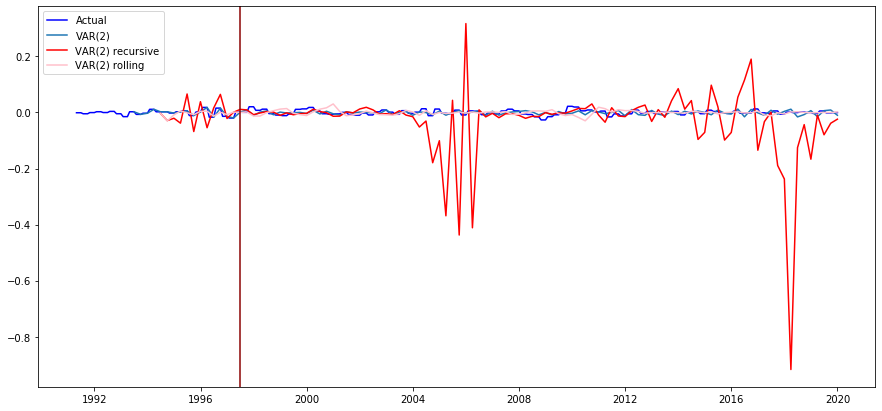

In [148]:
figure, axe = plt.subplots(figsize=(15,7))
#axe.plot(artrainprediction, color='green' , label='AR(8)')
#axe.plot(artestprediction, color='green')
axe.plot(yty_var_tot3, color='blue', label='Actual')
axe.plot(var.predict(regressors), label='VAR(2)')
axe.plot(recursiveVARForecast,color="red", label='VAR(2) recursive')
axe.plot(rollingVARForecast,color="pink", label='VAR(2) rolling')
axe.axvline(Y_train.index[-1], color = 'darkred')
plt.legend()
plt.show()

## Comparaison de tous les modèles

## Modèles rolling

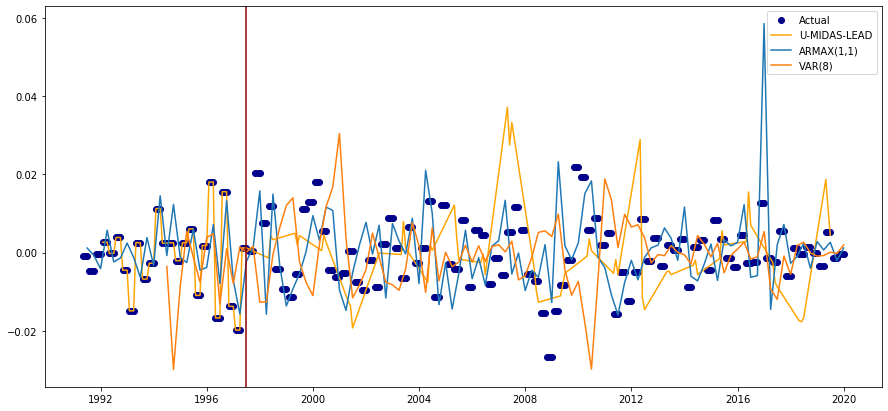

In [149]:
figure, axe = plt.subplots(figsize=(15,7))

#axe.plot(artrainprediction, color='green' , label='AR(8) not rolling')
#axe.plot(artestprediction, color='green')
axe.plot(yty_var_tot3, marker = 'o', linestyle='', color='darkblue', label='Actual')
axe.plot(rollingMIDASForecast, color='orange', label='U-MIDAS-LEAD')
axe.plot(rollingSARIMAXForecast, label='ARMAX(1,1)')
axe.plot(rollingVARForecast, label='VAR(8)')
axe.axvline(Y_train.index[-1], color = 'darkred')
#axe.set_ylim([-0.015,0.018])

plt.legend()
plt.show()
figure.savefig('modelsforecastsrolling.png')

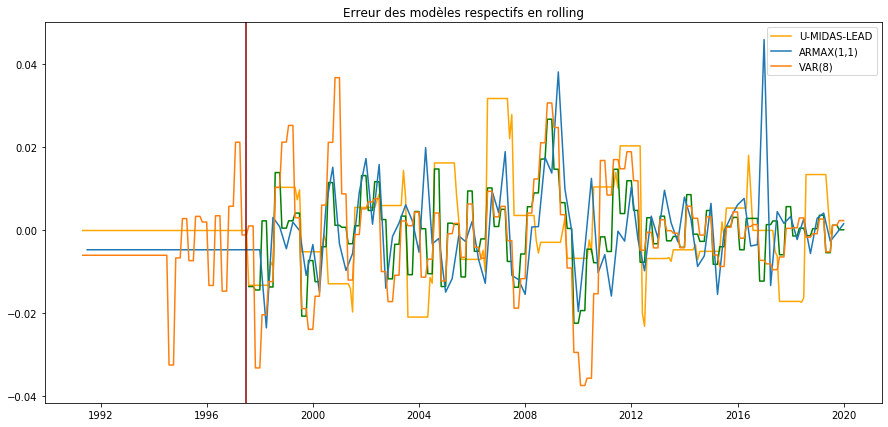

In [150]:
figure, axe = plt.subplots(figsize=(15,7))

axe.plot((rollingMIDASForecast[rollingMIDASForecast.columns[0]] - yty_var_tot3).bfill(), color='orange', label='U-MIDAS-LEAD')
#axe.plot(artrainprediction-yty_var_tot3, color='green' , label='AR(8) not rolling')
axe.plot(artestprediction-yty_var_tot3, color='green')
axe.plot((rollingSARIMAXForecast[rollingSARIMAXForecast.columns[0]] - yty_var_tot3).bfill(), label='ARMAX(1,1)')
axe.plot((rollingVARForecast[rollingVARForecast.columns[0]] - yty_var_tot3).bfill(), label='VAR(8)')
axe.axvline(Y_train.index[-1], color = 'darkred')

axe.set_title("Erreur des modèles respectifs en rolling")
plt.legend()
plt.show()
figure.savefig('modelserrorsrolling.png')

In [151]:
mseRollingMidas = ((yty_var_tot3 - rollingMIDASForecast[rollingMIDASForecast.columns[0]]).bfill()**2).mean()

train_mse_ar = (((artrainprediction-yty_var_tot3).dropna())**2).mean()
test_mse_ar = (((artestprediction-yty_var_tot3).dropna())**2).mean()

mseRollingSarx = ((staticSARIMAXForecast-yty_var_tot3).bfill().iloc[:len(X_train)]**2).mean()

mseRollingVAR = ((yty_var_tot3 - rollingVARForecast[rollingVARForecast.columns[0]]).bfill()**2).mean()

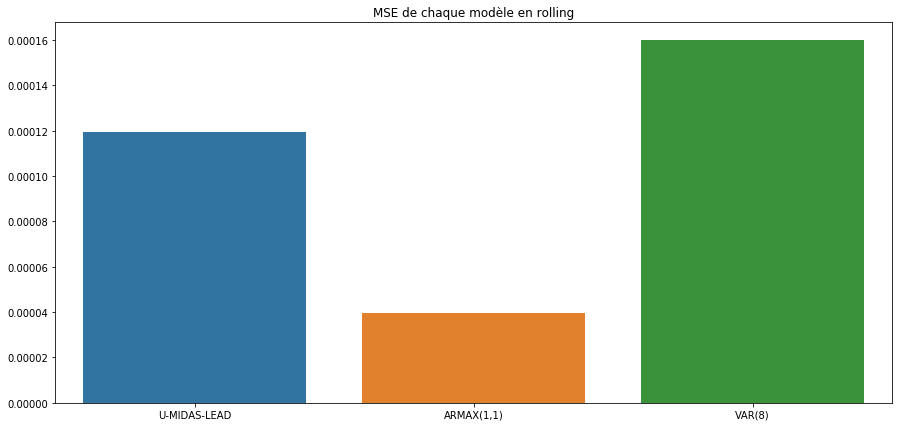

In [152]:
figure, axe = plt.subplots(figsize=(15,7))

sns.barplot(x=['U-MIDAS-LEAD', 'ARMAX(1,1)','VAR(8)'],y=[mseRollingMidas,mseRollingSarx, mseRollingVAR],ax=axe)
axe.set_title('MSE de chaque modèle en rolling')
plt.show()
figure.savefig('modelsmserolling.png')

## Modèles récursifs

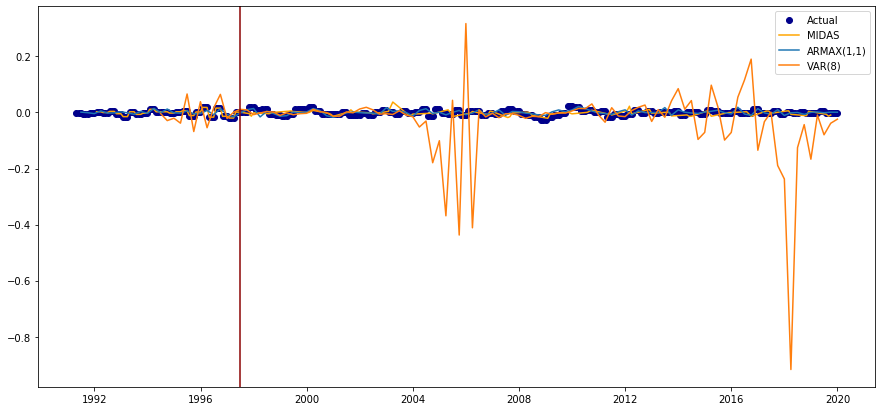

In [153]:
figure, axe = plt.subplots(figsize=(15,7))

#axe.plot(artrainprediction, color='green' , label='AR(8) not rolling')
#axe.plot(artestprediction, color='green')
axe.plot(yty_var_tot3, marker = 'o', linestyle='', color='darkblue', label='Actual')
axe.plot(recursiveMIDASForecast, color='orange', label='MIDAS')
axe.plot(recursiveSARIMAXForecast, label='ARMAX(1,1)')
axe.plot(recursiveVARForecast, label='VAR(8)')
axe.axvline(Y_train.index[-1], color = 'darkred')
#axe.set_ylim([-0.015,0.018])

plt.legend()
plt.show()
figure.savefig('modelsforecastsrecursive.png')

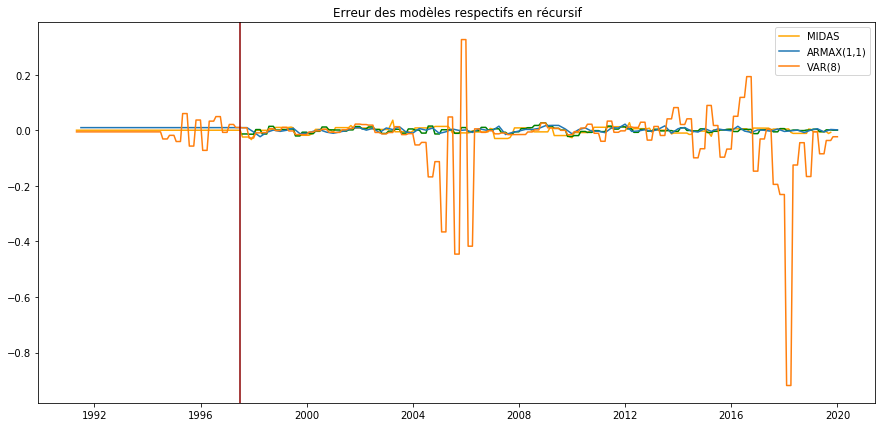

In [154]:
figure, axe = plt.subplots(figsize=(15,7))

axe.plot((recursiveMIDASForecast[recursiveMIDASForecast.columns[0]] - yty_var_tot3).bfill(), color='orange', label='MIDAS')
#axe.plot(artrainprediction-yty_var_tot3, color='green' , label='AR(8) not rolling')
axe.plot(artestprediction-yty_var_tot3, color='green')
axe.plot((recursiveSARIMAXForecast[recursiveSARIMAXForecast.columns[0]] - yty_var_tot3).bfill(), label='ARMAX(1,1)')
axe.plot((recursiveVARForecast[recursiveVARForecast.columns[0]] - yty_var_tot3).bfill(), label='VAR(8)')
axe.axvline(Y_train.index[-1], color = 'darkred')

axe.set_title("Erreur des modèles respectifs en récursif")
plt.legend()
plt.show()
figure.savefig('modelserrorsrecursive.png')

In [155]:
mseRecursiveMidas = ((yty_var_tot3 - rollingMIDASForecast[rollingMIDASForecast.columns[0]]).bfill()**2).mean()

train_mse_ar = (((artrainprediction-yty_var_tot3).dropna())**2).mean()
test_mse_ar = (((artestprediction-yty_var_tot3).dropna())**2).mean()

mseRecursiveSarx = ((staticSARIMAXForecast-yty_var_tot3).bfill().iloc[:len(X_train)]**2).mean()

mseRecursiveVAR = ((yty_var_tot3 - rollingVARForecast[rollingVARForecast.columns[0]]).bfill()**2).mean()

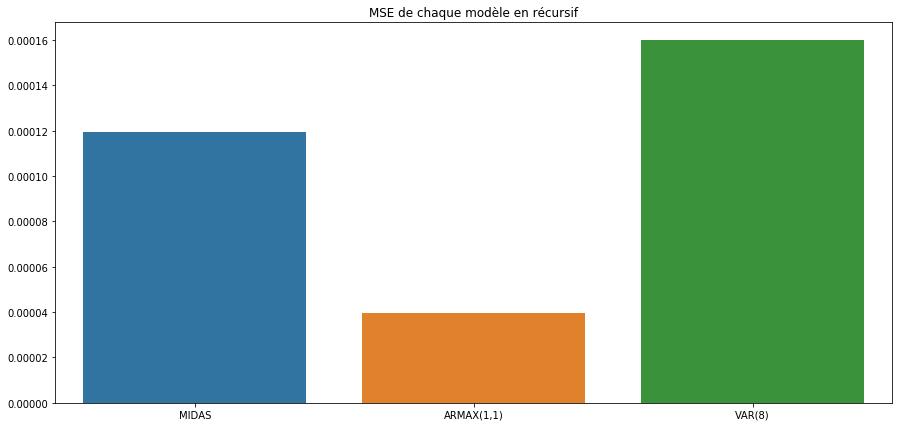

In [156]:
figure, axe = plt.subplots(figsize=(15,7))

sns.barplot(x=['MIDAS', 'ARMAX(1,1)','VAR(8)'],y=[mseRecursiveMidas,mseRecursiveSarx, mseRecursiveVAR],ax=axe)
axe.set_title('MSE de chaque modèle en récursif')
plt.show()
figure.savefig('modelsmserecursive.png')

## Modèles statiques

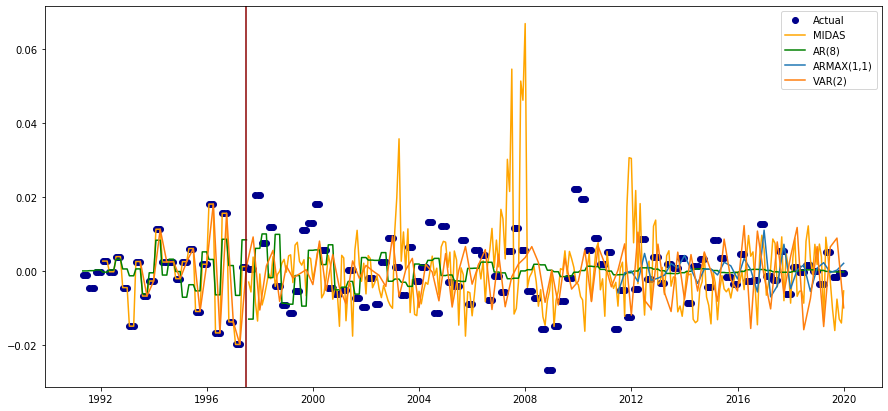

In [117]:
figure, axe = plt.subplots(figsize=(15,7))

axe.plot(yty_var_tot3, marker = 'o', linestyle='', color='darkblue', label='Actual')
axe.plot(toreallyplot, color='orange', label='MIDAS')
axe.plot(toreallyplot2, color='orange')
axe.plot(artrainprediction, color='green' , label='AR(8)')
axe.plot(artestprediction, color='green')
axe.plot(staticSARIMAXForecast, label='ARMAX(1,1)')
axe.plot(var.predict(regressors), label='VAR(2)')
axe.axvline(Y_train.index[-1], color = 'darkred')
#axe.set_ylim([-0.015,0.018])

plt.legend()
plt.show()
figure.savefig('modelsforecasts.png')

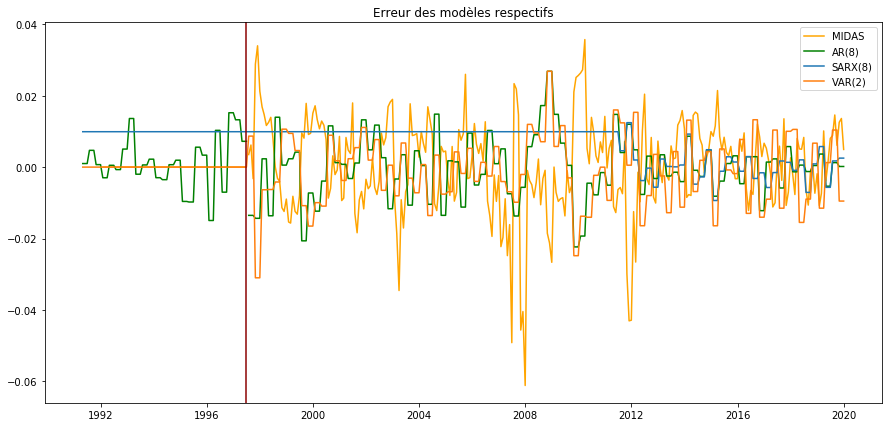

In [118]:
figure, axe = plt.subplots(figsize=(15,7))

axe.plot(yty_var_tot3.iloc[len(yty_var_tot3) - len(toreallyplot2) - len(toreallyplot):len(yty_var_tot3) - len(toreallyplot2)] - toreallyplot, color='orange', label='MIDAS')
axe.plot((yty_var_tot3 - toreallyplot2).dropna(), color='orange')
axe.plot(artrainprediction-yty_var_tot3, color='green' , label='AR(8)')
axe.plot(artestprediction-yty_var_tot3, color='green')
axe.plot((staticSARIMAXForecast-yty_var_tot3).bfill(), label='SARX(8)')

axe.plot((var.predict(regressors)-yty_var_tot3).bfill(), label='VAR(2)')

axe.axvline(Y_train.index[-1], color = 'darkred')

axe.set_title("Erreur des modèles respectifs")
plt.legend()
plt.show()
figure.savefig('modelserrors.png')

In [119]:
train_mse_midas = ((yty_var_tot3.iloc[len(yty_var_tot3) - len(toreallyplot2) - len(toreallyplot):len(yty_var_tot3) - len(toreallyplot2)] - toreallyplot)**2).mean()
test_mse_midas = (((yty_var_tot3 - toreallyplot2).dropna())**2).mean()

train_mse_ar = (((artrainprediction-yty_var_tot3).dropna())**2).mean()
test_mse_ar = (((artestprediction-yty_var_tot3).dropna())**2).mean()

train_mse_sarx = ((staticSARIMAXForecast-yty_var_tot3).bfill().iloc[:len(X_train)]**2).mean()

test_mse_sarx = ((staticSARIMAXForecast-yty_var_tot3).bfill().iloc[len(X_train):]**2).mean()

train_mse_var = ((((var.predict(regressors)-yty_var_tot3).bfill())**2).iloc[:len(X_train)]).sum()
test_mse_var = ((((var.predict(regressors)-yty_var_tot3).bfill())**2).iloc[len(X_train):]).sum()

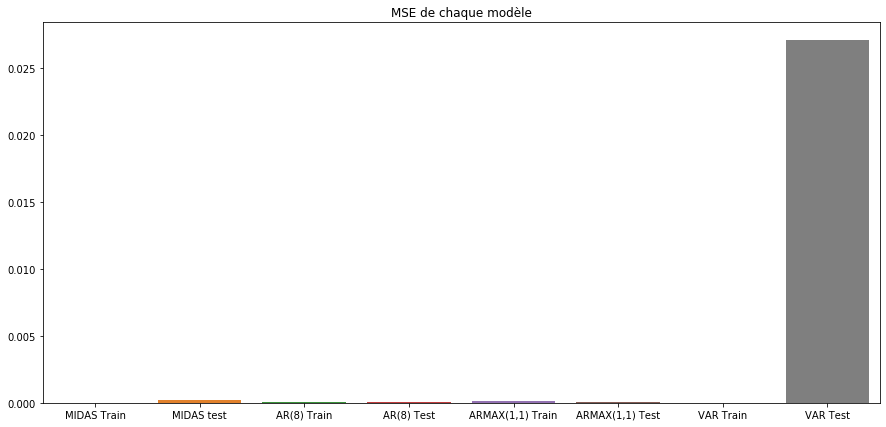

In [120]:
figure, axe = plt.subplots(figsize=(15,7))

sns.barplot(x=['MIDAS Train','MIDAS test','AR(8) Train','AR(8) Test', 'ARMAX(1,1) Train', 'ARMAX(1,1) Test','VAR Train', 'VAR Test'],y=[train_mse_midas,test_mse_midas,train_mse_ar,test_mse_ar,train_mse_sarx,test_mse_sarx,train_mse_var,test_mse_var],ax=axe)
axe.set_title('MSE de chaque modèle')
plt.show()
figure.savefig('modelsmse.png')

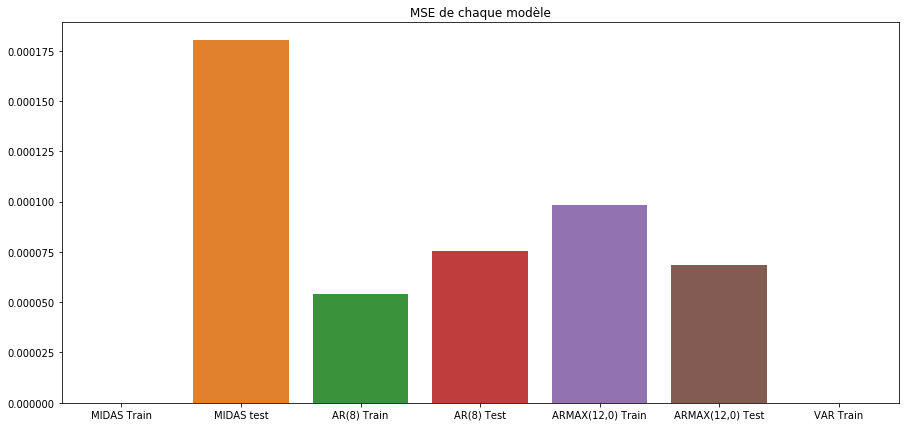

In [121]:
figure, axe = plt.subplots(figsize=(15,7))

sns.barplot(x=['MIDAS Train','MIDAS test','AR(8) Train','AR(8) Test', 'ARMAX(12,0) Train', 'ARMAX(12,0) Test','VAR Train'],y=[train_mse_midas,test_mse_midas,train_mse_ar,test_mse_ar,train_mse_sarx,test_mse_sarx,train_mse_var],ax=axe)
axe.set_title('MSE de chaque modèle')
plt.show()
figure.savefig('modelsmse2.png')

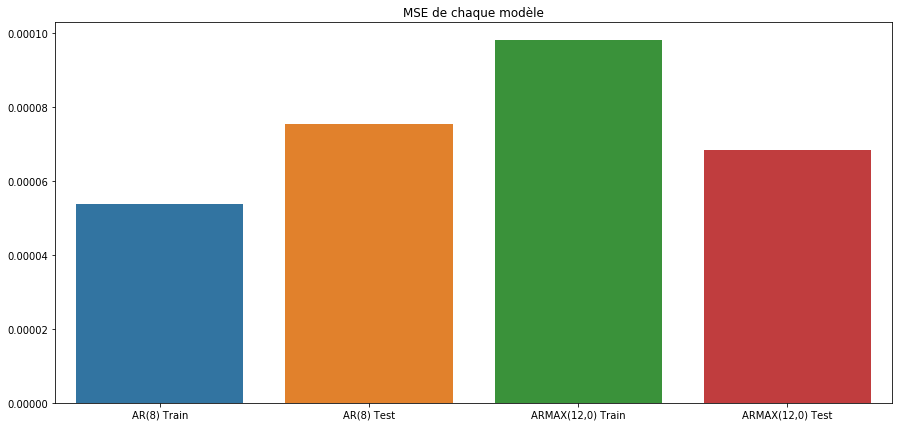

In [122]:
figure, axe = plt.subplots(figsize=(15,7))

sns.barplot(x=['AR(8) Train','AR(8) Test', 'ARMAX(12,0) Train', 'ARMAX(12,0) Test'],y=[train_mse_ar,test_mse_ar,train_mse_sarx,test_mse_sarx],ax=axe)
axe.set_title('MSE de chaque modèle')
plt.show()
figure.savefig('modelsmse3.png')

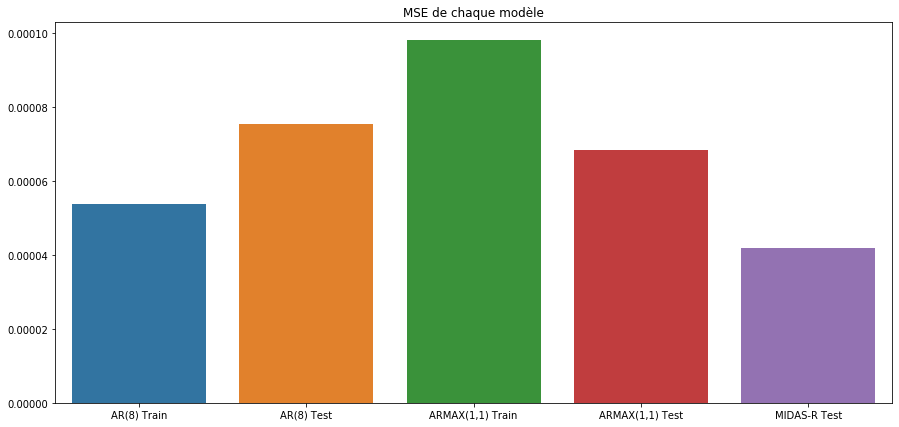

In [123]:
test_mse_midasr = 4.178053e-05

figure, axe = plt.subplots(figsize=(15,7))

sns.barplot(x=['AR(8) Train','AR(8) Test', 'ARMAX(1,1) Train', 'ARMAX(1,1) Test','MIDAS-R Test'],y=[train_mse_ar,test_mse_ar,train_mse_sarx,test_mse_sarx,test_mse_midasr],ax=axe)
axe.set_title('MSE de chaque modèle')
plt.show()
figure.savefig('modelsmse4.png')

### Visualisation des résultats intégrés